<a href="https://colab.research.google.com/github/amasoudi1/U-NET-For-RFG-System/blob/master/UNET_Fixed_Gantry3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q pyyaml  # pyyaml is an optional
!pip install -U -q PyDrive  # PyDrive you can upload/download read and write data

In [0]:
#import tensorflow as tf
#from tensorflow.keras import layers
#from tensorflow.python.client import device_lib


#print(tf.VERSION)
#print(tf.keras.__version__)
#device_lib.list_local_devices()

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
cd /content/gdrive/'My Drive'/'Colab Notebooks'/

/content/gdrive/My Drive/Colab Notebooks


In [0]:
ls

data_label/           rfg_v3.h5                 trainHistoryDict
data_reconstruction/  rfg_v4.h5                 trainHistoryDictV3
FbpConvNet.ipynb      test_data/                train_images_128/
model100.h5           test_data_128/            train_images_norm_128/
model100v2.h5         test_images_128/          training/
model100v3.h5         test_images_norm_128/     train_label_conv_rfg_100/
model100v4.h5         test_label_conv_rfg_100/  train_labels_128/
model100v5.h5         test_labels_128/          train_labels_norm_128/
model1.h5             test_labels_norm_128/     train_rec_conv_rfg_100/
model.h5              test_rec_conv_rfg_100/    UNET_Fixed_Gantry2.ipynb
rfg.h5                train_data/               UNET_Fixed_Gantry3.ipynb
rfg_v2.h5             train_data_128/           Untitled0.ipynb


In [0]:
import os
import sys

try:
 device_name = os.environ['COLAB_TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

TPU not found


[186 271  55 480  23 199 404 213 494  56 325 253 154 138 211 358 441 292
  44  77  39  93 174 447 311  45 297 100 474 177 300 338 465   2 146  67
 112  88 438 370 487 307 197 219  38 105 280 110 405 206]
Done With Data


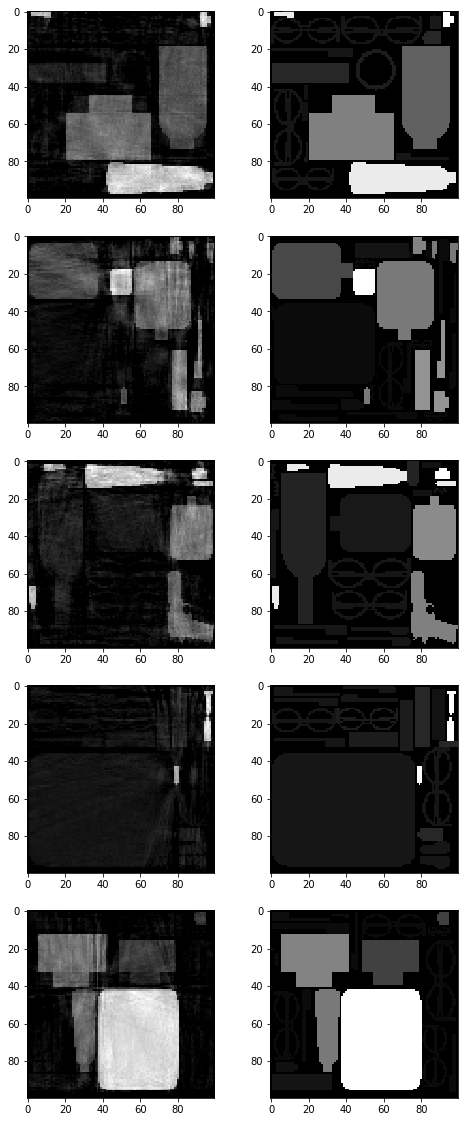

In [0]:
#from tensorflow.keras.models import *
#from tensorflow.keras.layers import *
#from tensorflow.keras.optimizers import *
#from tensorflow.keras.initializers import *
#from tf.keras.callbacks import ModelCheckpoint, LearningRateScheduler
#from tf.keras import backend as keras

from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint ,Callback
from keras.initializers import *

import numpy as np
import scipy.io as sc
import os
import sys
from sklearn.utils import shuffle
#from scipy.ndimage import imread
from imageio import imread
#from scipy.misc import imresize
import matplotlib.pyplot as plt

#np.random.seed(0)
#tf.set_random_seed(0)
#print(tf.VERSION)
#print(tf.keras.__version__)


train_images = np.zeros(shape=(450,100,100,1))
train_labels = np.zeros(shape=(450,100,100,1))

test_images = np.zeros(shape=(50,100,100,1))
test_labels = np.zeros(shape=(50,100,100,1))

indx = np.arange(500)
np.random.shuffle(indx)
print(indx[450:500])

# --- get training data ---
images_location = "./data_reconstruction/"
labels_location = "./data_label/"

for i in range(450):    
    image_temp = sc.loadmat(images_location + str(4*indx[i]+1) + ".mat")    
    train_images[i,:,:]   = np.expand_dims(np.array(image_temp['r']),axis=2)
    
    label_temp = sc.loadmat(labels_location + str(4*indx[i]+1) + ".mat")    
    train_labels[i,:,:]   = np.expand_dims(np.array(label_temp['t']),axis=2)
    
                
# --- get test data ---
#images_location = "./test_rec_conv_rfg_100/"
#labels_location = "./test_label_conv_rfg_100/"
      
counter = 0  
for i in range(450,500):      
    image_temp = sc.loadmat(images_location + str(4*indx[i]+1) + ".mat")    
    test_images[counter,:,:]   = np.expand_dims(np.array(image_temp['r']),axis=2)
    
    label_temp = sc.loadmat(labels_location + str(4*indx[i]+1) + ".mat")    
    test_labels[counter,:,:]   = np.expand_dims(np.array(label_temp['t']),axis=2)
    counter += 1
      
#train_images = 1*(train_images - train_images.min()) / (train_images.max() - train_images.min())
#train_labels = 1*(train_labels - train_labels.min()) / (train_labels.max() - train_labels.min())      
      
print("Done With Data")
fix, ax = plt.subplots(5,2, figsize=(8,20))
for i in range(5):
    ax[i,0].imshow(train_images[i,:,:,0], cmap='gray')
    ax[i,1].imshow(train_labels[i,:,:,0], cmap='gray')
plt.show()

#fix, ax = plt.subplots(1,2, figsize=(8,20))
#ax[0].imshow(train_images[0,:,:,0], cmap='gray')
#ax[1].imshow(train_labels[0,:,:,0], cmap='gray')
#plt.show()

In [0]:
# Defining
SEED = 42
#initializer = RandomNormal(mean=0.0, stddev=0.05, seed = SEED) 
initializer = glorot_normal(seed = SEED) 
inputs = Input(shape=(100,100,1))  # Returns a placeholder tensor

### Layers :
# LEVEL 1
L10 = Conv2D(1, (1, 1), activation='relu', padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(inputs)
L11 = Conv2D(64, (1, 1), activation='relu', padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L10)
L11 = BatchNormalization()(L11)
L12 = Conv2D(64, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L11)
L12 = BatchNormalization()(L12)
L13 = Conv2D(64, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L12)
L13 = BatchNormalization()(L13)

# LEVEL 2
L20 = MaxPooling2D(pool_size=(2, 2), padding='valid')(L13)
L21 = Conv2D(128, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L20)
L21 = BatchNormalization()(L21)
L22 = Conv2D(128, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L21)
L22 = BatchNormalization()(L22)

# LEVEL 3
L30 = MaxPooling2D(pool_size=(2, 2), padding='valid')(L22)
L31 = Conv2D(256, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L30)
L31 = BatchNormalization()(L31)
L32 = Conv2D(256, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L31)
L32 = BatchNormalization()(L32)

# LEVEL 4
L40 = MaxPooling2D(pool_size=(2, 2), padding='valid')(L32)
L41 = Conv2D(512, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L40)
L41 = BatchNormalization()(L41)
L42 = Conv2D(512, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L41)
L42 = BatchNormalization()(L42)

# LEVEL 5
L50 = MaxPooling2D(pool_size=(2, 2), padding='valid')(L42)
L51 = Conv2D(1024, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L50)
L51 = BatchNormalization()(L51)
L52 = Conv2D(1024, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L51)
L52 = BatchNormalization()(L52)

# LEVEL 4
L43_in = Conv2DTranspose(256, (3, 3), activation='relu' , strides=(2, 2) ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L52)
#L43_in = UpSampling2D(size=(2,2))(L52)
L43_in = BatchNormalization()(L43_in)
L43 = Conv2D(512, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(concatenate([L42,L43_in], axis = 3))
L43 = BatchNormalization()(L43)
L44 = Conv2D(512, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L43)
L44 = BatchNormalization()(L44)

# LEVEL 3
L33_in = Conv2DTranspose(128, (3, 3), activation='relu', strides=(2, 2) ,padding='valid',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L44)
#L33_in = UpSampling2D(size=(2,2))(L44)
L33_in = BatchNormalization()(L33_in)
L33 = Conv2D(256, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(concatenate([L32,L33_in], axis = 3))
L33 = BatchNormalization()(L33)
L34 = Conv2D(256, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L33)
L34 = BatchNormalization()(L34)

# LEVEL 2
L23_in = Conv2DTranspose(64, (3, 3), activation='relu' , strides=(2, 2) ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L34)
#L23_in = UpSampling2D(size=(2,2))(L34)
L23_in = BatchNormalization()(L23_in)
L23 = Conv2D(128, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(concatenate([L22,L23_in], axis = 3))
L23 = BatchNormalization()(L23)
L24 = Conv2D(128, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L23)
L24 = BatchNormalization()(L24)

# LEVEL 1
L14_in = Conv2DTranspose(32, (3, 3), activation='relu' , strides=(2, 2) ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L24)
#L14_in = UpSampling2D(size=(2,2))(L24)
L14_in = BatchNormalization()(L14_in)
L14 = Conv2D(64, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(concatenate([L13,L14_in], axis = 3))
L14 = BatchNormalization()(L14)
L15 = Conv2D(64, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L14)
L15 = BatchNormalization()(L15)
L16 = Conv2D(1, (1, 1), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L15)
feed_forward = Add()([L10,L16])
L17 = Conv2D(1, (1, 1), padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(feed_forward)


model = Model(inputs=inputs, outputs=L17)
model.summary()




__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
conv2d_67 (Conv2D)              (None, 100, 100, 1)  2           input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_68 (Conv2D)              (None, 100, 100, 64) 128         conv2d_67[0][0]                  
__________________________________________________________________________________________________
batch_normalization_70 (BatchNo (None, 100, 100, 64) 256         conv2d_68[0][0]                  
__________________________________________________________________________________________________
conv2d_69 

In [0]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(horizontal_flip = True, vertical_flip = True).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(horizontal_flip = True, vertical_flip = True).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

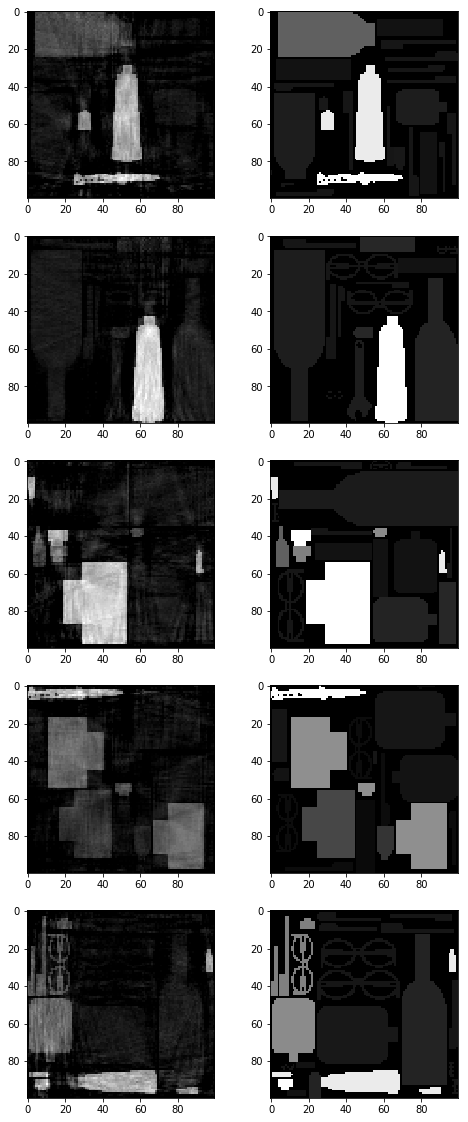

In [0]:

image_batch, mask_batch = next(my_generator(train_images, train_labels, 5))
fix, ax = plt.subplots(5,2, figsize=(8,20))
for i in range(5):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0], cmap='gray')
plt.show()

In [0]:
#sgd = SGD(lr=1e-4, momentum=0.99, nesterov = True, clipvalue=0.01)
#sgd = SGD(lr=1, momentum=0.99, clipvalue=0.01)
#sgd = tf.train.MomentumOptimizer(learning_rate = 0.01, momentum=0.99)

#class LossHistory(Callback):
#    def on_train_begin(self, logs={}):
#        self.losses = []
#
#    def on_batch_end(self, batch, logs={}):
#        self.losses.append(logs.get('loss'))

model.compile(Adam(lr = 0.01), loss='mean_squared_error', metrics=['mean_absolute_error'])
#model.compile(sgd, loss='mean_squared_error', metrics=['mean_absolute_error'])

weight_saver = ModelCheckpoint('./rfg_v4.h5', monitor='val_loss',
                               save_best_only=True, save_weights_only=True)

#annealer = LearningRateScheduler(lambda x: 0.99 ** x)

In [0]:

#model.load_weights('rfg.h5')
#model.compile(Adam(lr = 0.01), loss='mean_squared_error', metrics=['mean_absolute_error'])
#loss, acc = model.evaluate(train_images,train_labels)
#print(loss)
#print(acc)

#history = LossHistory()
#hist = model.fit(train_images, train_labels, batch_size = 32, epochs = 2000, validation_data = (test_images,test_labels), 
#          shuffle = True ,verbose = 1, callbacks = [weight_saver,history])#, annealer])
hist = model.fit_generator(my_generator(train_images, train_labels, 32), validation_data = (test_images,test_labels),
                           epochs=1000, verbose=2, shuffle=True,
                           steps_per_epoch = 64,
                           callbacks = [weight_saver])#, annealer])

Epoch 1/1000
 - 29s - loss: 88674.5350 - mean_absolute_error: 255.3931 - val_loss: 38978.0975 - val_mean_absolute_error: 140.2646
Epoch 2/1000
 - 23s - loss: 37211.7762 - mean_absolute_error: 106.0765 - val_loss: 33724.2997 - val_mean_absolute_error: 100.3435
Epoch 3/1000
 - 23s - loss: 35855.1995 - mean_absolute_error: 101.9098 - val_loss: 33283.8889 - val_mean_absolute_error: 99.3772
Epoch 4/1000
 - 22s - loss: 35831.2149 - mean_absolute_error: 100.7788 - val_loss: 33185.4356 - val_mean_absolute_error: 99.8177
Epoch 5/1000
 - 22s - loss: 36518.7214 - mean_absolute_error: 101.9616 - val_loss: 32698.1825 - val_mean_absolute_error: 95.2103
Epoch 6/1000
 - 23s - loss: 36267.9693 - mean_absolute_error: 100.3939 - val_loss: 32518.0606 - val_mean_absolute_error: 93.2265
Epoch 7/1000
 - 23s - loss: 35521.5198 - mean_absolute_error: 99.6472 - val_loss: 32577.4911 - val_mean_absolute_error: 95.1251
Epoch 8/1000
 - 22s - loss: 35213.8238 - mean_absolute_error: 97.4878 - val_loss: 32571.1436 - v

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


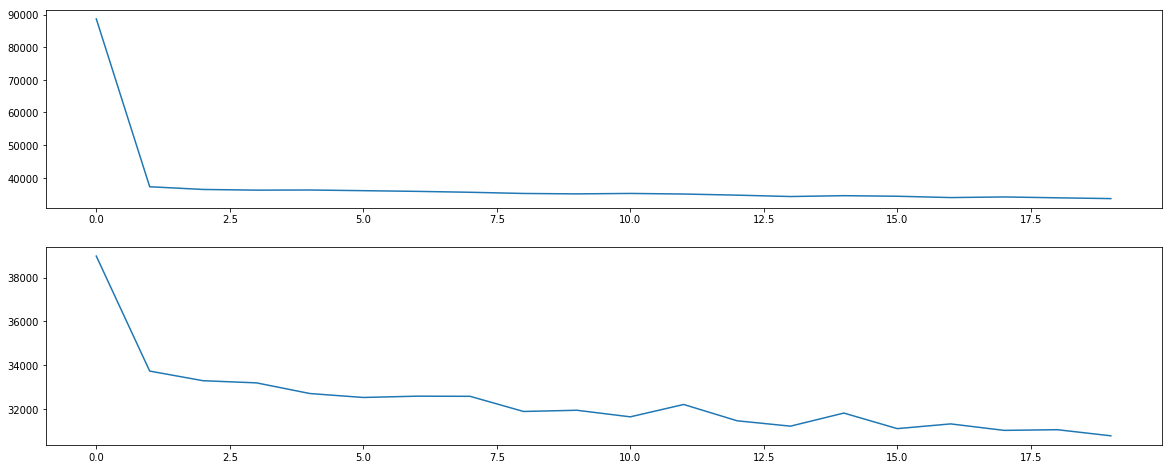

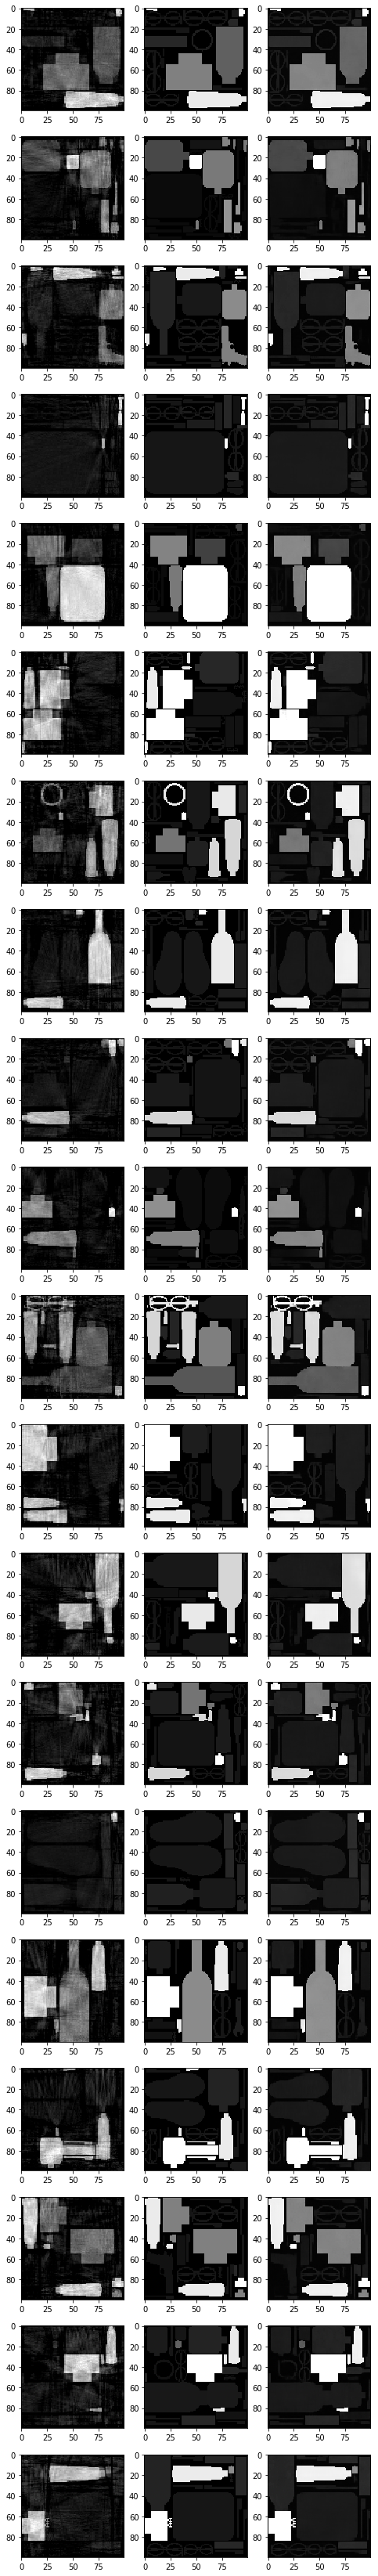

In [0]:
#import pickle
#file_pickle = open('trainHistoryDictV3', 'wb') 
#pickle.dump(hist, file_pickle)
#file_pickle.close()

#model.load_weights('model1.h5')

print(hist.history.keys())

index = 0
fix, ax = plt.subplots(2,1, figsize=(20,8))
#plt.yscale('log')
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
ax[0].plot(loss_train[0:20])
ax[1].plot(loss_val[0:20])

#image_batch, mask_batch = next(my_generator(train_images, train_labels, 5))
fix, ax = plt.subplots(20,3, figsize=(8,60))
for i in range(20):
    ax[i,0].imshow(train_images[i,:,:,0], cmap='gray')
    ax[i,1].imshow(train_labels[i,:,:,0], cmap='gray')
    temp = model.predict( np.expand_dims( np.expand_dims(train_images[i,:,:,0], axis = 0), axis = 3 ))
    ax[i,2].imshow(np.squeeze(temp), cmap='gray')
plt.show()

# Test
798.0172-22.4618

50/50 [==============================] - 0s 5ms/step
718.5250830078126
13.721005783081054


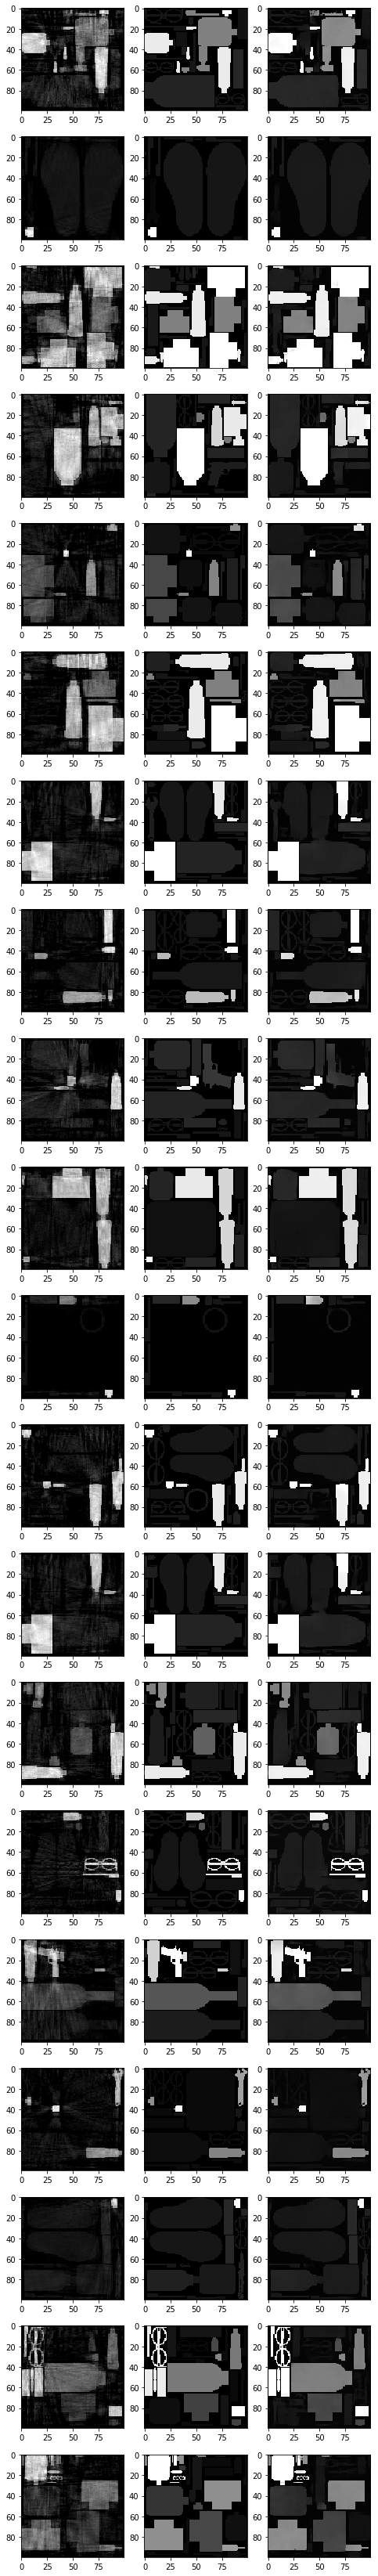

In [0]:
model.load_weights('rfg_v4.h5')
#model.compile(Adam(lr = 0.01), loss='mean_squared_error', metrics=['mean_absolute_error'])

loss, acc = model.evaluate(test_images,test_labels)
print(loss)
print(acc)
fix, ax = plt.subplots(20,3, figsize=(8,60))
for i in range(20):    
    ax[i,0].imshow(test_images[i,:,:,0], cmap='gray')
    ax[i,1].imshow(test_labels[i,:,:,0], cmap='gray')
    temp = model.predict( np.expand_dims( np.expand_dims(test_images[i,:,:,0], axis = 0), axis = 3 ))
    ax[i,2].imshow(np.squeeze(temp), cmap='gray')
plt.show()